In [247]:
from unittest.mock import inplace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from keras.src.callbacks import EarlyStopping
import random
import numpy as np
import tensorflow as tf
from keras.api.layers import Dense, Dropout
from keras.api.models import Sequential
from keras.api.regularizers import l1, l2
from keras.api.optimizers import Adam

In [248]:
def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def cw(df):
    c0, c1 = np.bincount(df["dir"])
    w0 = (1/c0) * (len(df)) / 2
    w1 = (1/c1) * (len(df)) / 2
    return {0:w0, 1:w1}

In [249]:
symbol = "EURUSD=X"
#start = "2022-08-27"
start = "2022-08-28"
end = "2024-08-22"
interval = '1h'
ptc = 0.000059
lags = 7

In [250]:
df = yf.download(symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
df.drop(columns=['Adj Close', 'Volume'], inplace=True)
#df.index = df.index.tz_convert('utc')
df['returns'] = np.log(df['Close'].div(df['Close'].shift(1)))
df['day_of_week'] = df.index.dayofweek
df['dir'] = np.where(df['returns'] > 0, 1,0)
df.dropna(inplace=True)
features = ["dir", 'Open', 'High', 'Low', 'Close', 'returns']

[*********************100%%**********************]  1 of 1 completed


In [251]:
copy = df.copy()
cols = []
for f in features:
    for lag in range(1, lags + 1):
        col = "{}_lag_{}".format(f, lag)
        copy[col] = copy[f].shift(lag)
        cols.append(col)
copy.dropna(inplace=True)
cols.append('day_of_week')
split = int(len(copy)* 0.8)
train = copy.iloc[:split].copy()
test = copy.iloc[split:].copy()
mu, std = train.mean(), train.std()
train_standardized = (train-mu) / std

In [252]:
### Parameters
dropout = 0.3

In [253]:
optimizer = Adam(learning_rate = 0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

set_seeds(100)
model = Sequential()
model.add(Dense(32, input_dim = len(cols), activity_regularizer = None ,activation = "relu", kernel_regularizer=l2(0.001), )) 
model.add(Dropout(dropout, seed = 100))
model.add(Dense(32, activation = "relu", activity_regularizer = None, kernel_regularizer=l2(0.001),))
model.add(Dense(32, activation = "relu", activity_regularizer = None, kernel_regularizer=l2(0.001),))    
model.add(Dropout(dropout, seed = 100))        
model.add(Dense(1, activation = "sigmoid")) 
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

model.fit(x=train_standardized[cols], y=train['dir'], epochs=30, verbose=False,
          validation_split=0.2, shuffle=False, class_weight=cw(train), callbacks=[early_stopping] )


C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


In [254]:
loss_train, accuracy_train =  model.evaluate(train_standardized[cols], train['dir'])
predict = model.predict(train_standardized[cols])

test_standardized = (test-mu) / std
loss_test, accuracy_test =  model.evaluate(test_standardized[cols], test['dir'])
test['probability'] = model.predict(test_standardized[cols])
threshold = 0.53
test['position'] = np.where(test.probability < (1-threshold), -1, np.nan)
test['position'] = np.where(test.probability > threshold, 1, test.position)
test['position'] = test.position.ffill()
test['strategy'] = test['position'] * test['returns']
test['creturns'] = test['returns'].cumsum().apply(np.exp)
test['cstrategy'] = test['strategy'].cumsum().apply(np.exp)
test['trades'] = test.position.diff().abs()
test['strategy_net'] = test.strategy - test.trades * ptc
test['cstrategy_net'] = test['strategy_net'].cumsum().apply(np.exp)

308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5354 - loss: 0.7367
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5350 - loss: 0.7384
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [255]:
print(f"Loss: {loss_train}")
print(f"Accuracy: {accuracy_train}")

Loss: 0.7365191578865051
Accuracy: 0.5395258665084839


In [256]:
print(f"Loss: {loss_test}")
print(f"Accuracy: {accuracy_test}")

Loss: 0.7389277815818787
Accuracy: 0.5215622186660767


<Axes: >

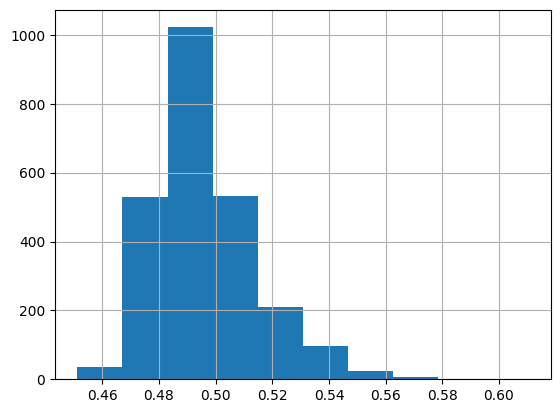

In [257]:
test.probability.hist()

In [258]:
test.creturns.corr(test.cstrategy)

0.8864333808449487

In [259]:
test.position.value_counts()

position
 1.0    1789
-1.0     651
Name: count, dtype: int64

308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Axes: xlabel='Datetime'>

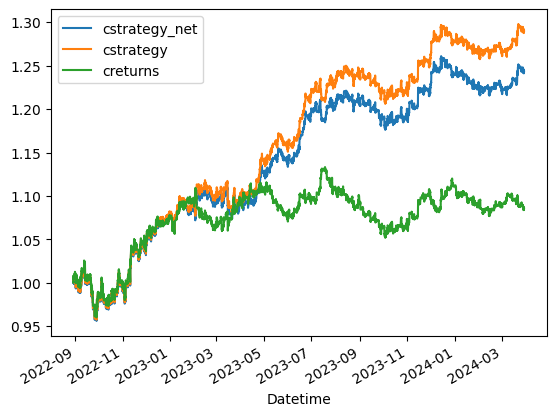

In [260]:
train['probability'] = model.predict(train_standardized[cols])
threshold = 0.53
train['position'] = np.where(train.probability < (1-threshold), -1, np.nan)
train['position'] = np.where(train.probability > threshold, 1, train.position)
train['position'] = train.position.ffill()
train['strategy'] = train['position'] * train['returns']
train['creturns'] = train['returns'].cumsum().apply(np.exp)
train['cstrategy'] = train['strategy'].cumsum().apply(np.exp)
train['trades'] = train.position.diff().abs()
train['strategy_net'] = train.strategy - train.trades * ptc
train['cstrategy_net'] = train['strategy_net'].cumsum().apply(np.exp)
train[['cstrategy_net', 'cstrategy', 'creturns']].plot()

<Axes: xlabel='Datetime'>

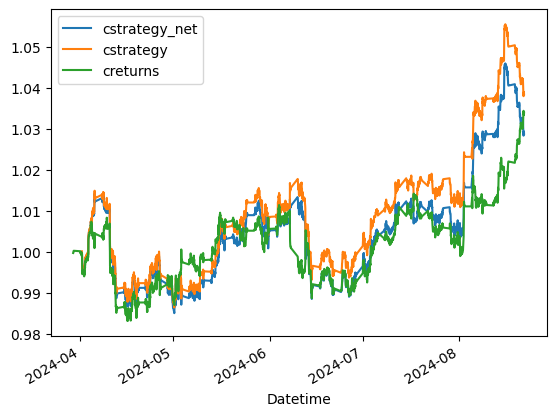

In [261]:
test[['cstrategy_net', 'cstrategy', 'creturns']].plot()

In [262]:
analysis = test.copy()
analysis.drop(columns = cols, inplace = True)
analysis.dropna(inplace = True)

In [263]:
analysis.cstrategy_net.iloc[-1]

1.0287994395524556

In [264]:
analysis

,Open,High,Low,Close,returns,dir,probability,position,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net
Datetime,,,,,,,,,,,,,,
2024-04-01 13:00:00+01:00,1.078749,1.078865,1.078051,1.078400,-0.000216,0,0.485802,1.0,-0.000216,0.999137,1.000000,0.0,-0.000216,0.999784
2024-04-01 14:00:00+01:00,1.078400,1.078516,1.077470,1.077702,-0.000647,0,0.518234,1.0,-0.000647,0.998491,0.999353,0.0,-0.000647,0.999138
2024-04-01 15:00:00+01:00,1.076658,1.076658,1.074229,1.074691,-0.002798,0,0.491325,1.0,-0.002798,0.995701,0.996561,0.0,-0.002798,0.996346
2024-04-01 16:00:00+01:00,1.074807,1.074807,1.073422,1.073537,-0.001074,0,0.535691,1.0,-0.001074,0.994632,0.995491,0.0,-0.001074,0.995276
2024-04-01 17:00:00+01:00,1.073537,1.073998,1.073422,1.073998,0.000430,1,0.539479,1.0,0.000430,0.995060,0.995919,0.0,0.000430,0.995704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-21 19:00:00+01:00,1.116321,1.117693,1.116321,1.116445,0.000447,1,0.459666,-1.0,-0.000447,1.034387,1.037950,0.0,-0.000447,1.028340
2024-08-21 20:00:00+01:00,1.116321,1.116321,1.115449,1.115573,-0.000781,0,0.474686,-1.0,0.000781,1.033579,1.038761,0.0,0.000781,1.029144
2024-08-21 21:00:00+01:00,1.115573,1.115822,1.115076,1.115324,-0.000223,0,0.480614,-1.0,0.000223,1.033348,1.038993,0.0,0.000223,1.029374


In [265]:
analysis['dir_position'] = np.where(analysis['probability'] < 0.47, 0, np.where(analysis['probability'] > 0.53, 1, np.nan))

In [266]:
analysis[(analysis.dir_position != analysis.dir) & (pd.notna(analysis.dir_position))]

,Open,High,Low,Close,returns,dir,probability,position,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net,dir_position
Datetime,,,,,,,,,,,,,,,
2024-04-01 16:00:00+01:00,1.074807,1.074807,1.073422,1.073537,-0.001074,0,0.535691,1.0,-0.001074,0.994632,0.995491,0.0,-0.001074,0.995276,1.0
2024-04-04 16:00:00+01:00,1.087075,1.087075,1.086602,1.086720,-0.000326,0,0.541846,1.0,-0.000326,1.006846,1.007716,0.0,-0.000326,1.007498,1.0
2024-04-05 16:00:00+01:00,1.082017,1.084599,1.082017,1.084363,0.001950,1,0.459171,-1.0,-0.001950,1.004663,1.012966,2.0,-0.002068,1.012150,0.0
2024-04-08 23:00:00+01:00,1.086248,1.086366,1.086248,1.086248,0.000000,0,0.536353,1.0,0.000000,1.006409,1.011208,2.0,-0.000118,1.010274,1.0
2024-04-09 16:00:00+01:00,1.086012,1.086248,1.085541,1.085894,-0.000109,0,0.544416,1.0,-0.000109,1.006081,1.010878,0.0,-0.000109,1.009945,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-20 08:00:00+01:00,1.108525,1.108893,1.107542,1.108893,0.000333,1,0.465228,-1.0,-0.000333,1.027390,1.045019,0.0,-0.000333,1.035343,0.0
2024-08-20 19:00:00+01:00,1.111852,1.112595,1.111852,1.112347,0.000334,1,0.459326,-1.0,-0.000334,1.030590,1.041774,0.0,-0.000334,1.032129,0.0
2024-08-20 21:00:00+01:00,1.112842,1.113338,1.112718,1.113338,0.000557,1,0.467403,-1.0,-0.000557,1.031508,1.040847,0.0,-0.000557,1.031210,0.0


In [267]:
analysis[(analysis.dir_position != analysis.dir) & (pd.notna(analysis.dir_position))].probability.describe()

count    110.000000
mean       0.519346
std        0.036960
min        0.451299
25%        0.468997
50%        0.534844
75%        0.544160
max        0.573768
Name: probability, dtype: float64

In [268]:
analysis[analysis.dir_position == analysis.dir]

,Open,High,Low,Close,returns,dir,probability,position,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net,dir_position
Datetime,,,,,,,,,,,,,,,
2024-04-01 17:00:00+01:00,1.073537,1.073998,1.073422,1.073998,0.000430,1,0.539479,1.0,0.000430,0.995060,0.995919,0.0,0.000430,0.995704,1.0
2024-04-04 08:00:00+01:00,1.084246,1.086130,1.084246,1.086012,0.001519,1,0.532662,1.0,0.001519,1.006190,1.007059,0.0,0.001519,1.006842,1.0
2024-04-04 19:00:00+01:00,1.086248,1.086248,1.085069,1.085305,-0.000977,0,0.469868,-1.0,0.000977,1.005535,1.008372,2.0,0.000859,1.008036,0.0
2024-04-04 22:00:00+01:00,1.084011,1.084246,1.083776,1.084011,0.000000,0,0.463241,-1.0,-0.000000,1.004336,1.009576,0.0,-0.000000,1.009239,0.0
2024-04-05 04:00:00+01:00,1.082837,1.083072,1.082720,1.082954,0.000108,1,0.551935,1.0,0.000108,1.003357,1.010780,2.0,-0.000010,1.010324,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-16 07:00:00+01:00,1.098780,1.098901,1.098418,1.098418,-0.000439,0,0.469572,-1.0,0.000439,1.017685,1.054519,0.0,0.000439,1.045002,0.0
2024-08-16 12:00:00+01:00,1.099747,1.099747,1.099264,1.099505,-0.000220,0,0.466278,-1.0,0.000220,1.018692,1.053476,0.0,0.000220,1.043969,0.0
2024-08-19 11:00:00+01:00,1.103753,1.104118,1.103387,1.103997,0.000221,1,0.532850,1.0,0.000221,1.022853,1.049654,2.0,0.000103,1.040059,1.0


In [269]:
analysis[analysis.dir_position == analysis.dir].probability.describe()

count    104.000000
mean       0.511383
std        0.039232
min        0.451198
25%        0.468416
50%        0.531583
75%        0.539340
max        0.610371
Name: probability, dtype: float64